# PyTorch Hypercolumn CNN  for Zurich Dataset

In [3]:
# import libraries
import os, sys
from sklearn import metrics
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from hypercolumn import HyperColumn
from unet import Unet

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import *
from helpers.helpers import *

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 128

# load data
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment', 
                             random_crop=False)
dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size)
dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size)

dataloader_train = DataLoader(dataset_train, batch_size=50, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=50, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=50, shuffle=False, num_workers=20)

In [5]:
def acc_with_filt(y_true, y_pred, label_to_ignore):
    """
    get accuracy ignoring a label in y_true
    :param y_true: ground truth (tensor)
    :param y_pred: predicted label (tensor)
    :param label_to_ignore: label to ignore
    :return: accuracy
    """
    y_true = y_true.numpy().flatten()
    y_pred = y_pred.numpy().flatten()
    filt = y_true != label_to_ignore
    return np.sum(np.equal(y_pred[filt], y_true[filt]))/len(y_true[filt])


def test(model, f_loss, dataloader, name, verbosity=False):
    with torch.no_grad():
        model.eval()
        loss = 0
        acc = []  # average accuracy
        for i_batch, (im, gt) in enumerate(dataloader):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            loss += f_loss(output, gt).cpu()
            _, pred = output.cpu().max(1, keepdim=True)
            acc.append(acc_with_filt(gt.cpu(), pred.cpu(), 0))

        loss /= len(dataloader.dataset)
        acc = np.mean(acc)
        if verbosity>0:
            print(name + ' set: Average loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(loss, acc * 100))
        return acc, loss

def predict(model, dataloader_pred):
    with torch.no_grad():
        model.eval()
        test_pred = torch.LongTensor()
        for i_batch, (im, gt) in enumerate(dataloader_pred):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            _, pred = output.cpu().max(1, keepdim=False)
            test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred.numpy()


def train(model, dataloader_train, dataloader_val, epochs, verbosity=0, plot=False):
    """
    Train a model for a given number of epochs
    :param model: Model to train
    :param dataloader_train: dataloader for training data
    :param dataloader_val: dataloader for test data
    :param epochs: number of epochs to train
    :param verbosity: verbosity level of status messages
    :return:
    """
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    weights = dataloader_train.dataset.weights
    weights[weights >= 10] = 10
    weights = torch.from_numpy(weights).float().cuda()
    f_loss = nn.CrossEntropyLoss(weight=weights, ignore_index=0)  # weight=weights,
    model.train()
    acc_tr_hist, acc_val_hist = [], []
    loss_tr_hist, loss_val_hist = [], []
    for epoch in range(epochs):
        # validation
        av_loss = 0

        for i_batch, (im, gt) in (tqdm(enumerate(dataloader_train)) if verbosity>1 else enumerate(dataloader_train)):
            im = im.cuda()
            gt = gt.cuda()
            opt.zero_grad()
            output = model(im)
            loss_out = f_loss(output, gt)
            av_loss += loss_out.cpu().detach().numpy()
            loss_out.backward()
            opt.step()

            if not i_batch % 100 and verbosity > 1:
                tqdm.write("Average loss: {:.2f}".format(av_loss/(i_batch+1)))
                
        if verbosity>0:
            print("Epoch %i:" % epoch)
        acc_tr, loss_tr = test(model, f_loss, dataloader_train, 'Train', verbosity=verbosity)
        acc_val, loss_val = test(model, f_loss, dataloader_val, 'Val', verbosity=verbosity)
        acc_tr_hist.append(acc_tr)
        acc_val_hist.append(acc_val)
        loss_tr_hist.append(loss_tr)
        loss_val_hist.append(loss_val)
        if plot:
            # plot accuracy history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), acc_tr_hist)
            ax.plot(np.arange(epoch+1), acc_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("OA")
            ax.set_ylim([0,1])
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set', 'Validation Set'])
            plt.savefig('Figures/hist_train_all_acc.pdf')
            plt.close()
            
            # plot loss history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), loss_tr_hist)
            ax.plot(np.arange(epoch+1), loss_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set','Validation Set'])
            plt.savefig('Figures/hist_train_all_loss.pdf')
            plt.close()

In [6]:
dataloader_train = DataLoader(dataset_train, batch_size=20, shuffle=True, num_workers=40)
dataloader_val = DataLoader(dataset_val, batch_size=40, shuffle=False, num_workers=40)
dataloader_test = DataLoader(dataset_test, batch_size=40, shuffle=False, num_workers=40)

In [7]:
train_bool = True
model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()

if train_bool:
    # Train network from scratch
    %time train(model, dataloader_train, dataloader_val, epochs=5, verbosity=1, plot=True)
    
    # save model
    state = {'model': model.state_dict(), 
             'n_epochs': 60,
             'loss_tr':0.
            }
    
    torch.save(state, 'models/model_all_cl.pytorch')

else:  # load saved model
    state = torch.load('models/model_all_cl.pytorch')
    model.load_state_dict(state['model'])

Epoch 0:
Train set: Average loss: 0.0970, Accuracy: 24.40%
Val set: Average loss: 0.0535, Accuracy: 27.89%
Epoch 1:
Train set: Average loss: 0.0917, Accuracy: 59.25%
Val set: Average loss: 0.0488, Accuracy: 59.42%
Epoch 2:
Train set: Average loss: 0.0902, Accuracy: 59.19%
Val set: Average loss: 0.0480, Accuracy: 62.08%
Epoch 3:
Train set: Average loss: 0.0891, Accuracy: 58.34%
Val set: Average loss: 0.0482, Accuracy: 59.99%
Epoch 4:
Train set: Average loss: 0.0880, Accuracy: 62.58%
Val set: Average loss: 0.0473, Accuracy: 63.96%
CPU times: user 5min 44s, sys: 1min 26s, total: 7min 10s
Wall time: 1min 43s


In [9]:
# class names and colors
names = dataset_train.names
colors = dataset_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != np.infty])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Roads' 'Buildings' 'Trees' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


In [10]:
# load data with overlap
#dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/4))
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2))
#dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/4))

#dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=10, shuffle=False, num_workers=20)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=10, shuffle=False, num_workers=20)
#dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=10, shuffle=False, num_workers=20)

In [11]:
preds = predict(model, dataloader_val_overlap)
preds = remove_overlap(dataset_val.imgs, preds[..., np.newaxis], np.arange(5), 
               patch_size=patch_size, stride=int(patch_size/2))
preds = np.concatenate(preds)

del dataset_val_overlap, dataloader_val_overlap

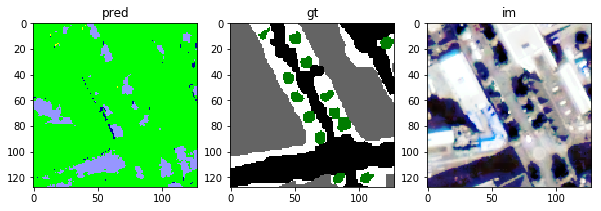

In [12]:
patch_idx = np.random.choice(len(preds))

fig, axes = plt.subplots(1, 3, figsize=(10,9))
axes[0].imshow(gt_label_to_color(preds[patch_idx,...,0], colors)*255)
axes[1].imshow(gt_label_to_color(dataset_val.gt_patches[patch_idx], colors) * 255)
axes[2].imshow(dataset_val.im_patches[patch_idx][..., :3])
_ = [axes[i].set_title(['pred','gt','im'][i]) for i in range(3)]

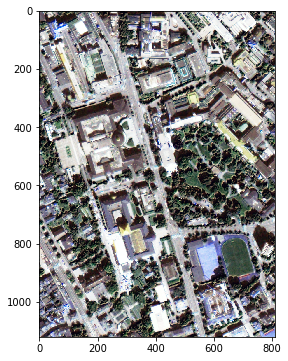

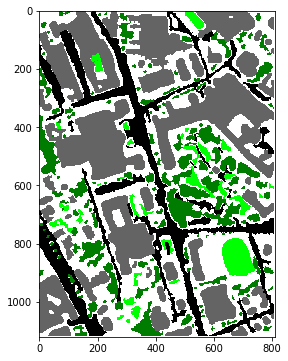

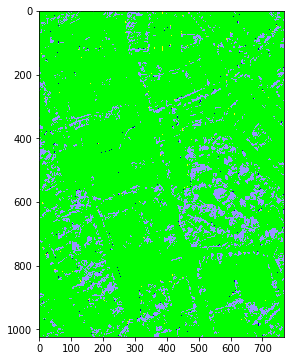

In [13]:
img_idx = 4

img = convert_patches_to_image(dataset_val.imgs, preds, img_idx, 
                               patch_size=patch_size, stride=patch_size, img_start=0)

# im
plt.figure(figsize=(6, 6))
plt.imshow(dataset_val.imgs[img_idx][..., :3])
plt.show()

# gt
plt.figure(figsize=(6, 6))
plt.imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)
plt.show()

# pred
plt.figure(figsize=(6, 6))
plt.imshow(gt_label_to_color(img[...,0], dataset_val.colors)*255)

In [14]:
f_loss = nn.NLLLoss(ignore_index=0)
p = test(model, f_loss, dataloader_train, "Train", verbosity=1)
p = test(model, f_loss, dataloader_val, "Val", verbosity=1)
p = test(model, f_loss, dataloader_test, "Test", verbosity=1)

Train set: Average loss: -0.0055, Accuracy: 8.82%
Val set: Average loss: -0.0030, Accuracy: 12.70%
Test set: Average loss: -0.0029, Accuracy: 21.04%


In [15]:
#preds_val = predict(model, dataloader_val)
#preds_train = predict(model, dataloader_train)

In [16]:
# Accuracy measures for each class

# Accuracy metrics
y_pred_flattened = np.asarray(preds.flatten()).astype('int')
y_test_flattened = np.asarray(dataset_val.gt_patches.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))

oa(y_test_flattened[filter_items], y_pred_flattened[filter_items])

                precision    recall  f1-score   support

         Roads      0.000     0.000     0.000    775759
     Buildings      0.000     0.000     0.000    966943
         Trees      0.000     0.000     0.000    654752
         Grass      0.129     0.988     0.228    367944
     Bare Soil      0.000     0.000     0.000     48828
         Water      0.031     0.001     0.001    249976
      Railways      0.000     0.000     0.000     26664
Swimming Pools      0.000     0.000     0.000         0

   avg / total      0.018     0.118     0.027   3090866



/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.11763143403822747